In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

%matplotlib inline

/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:49: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


In [2]:
df_interestrates = pd.read_csv('/Users/ir3n3br4t515/Desktop/index.csv')
df_zillowsale = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_State.csv')
df_zillowrent = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianRentalPrice_AllHomes.csv')
df_daysonzillow = pd.read_csv('/Users/ir3n3br4t515/Desktop/DaysOnZillow_State.csv')
df_sale_city = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_City.csv')
df_pricepsqft = pd.read_csv('/Users/ir3n3br4t515/Desktop/State_MedianListingPricePerSqft_AllHomes.csv')
df_salezip = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_Zip.csv')
df_saleneighborhood = pd.read_csv('/Users/ir3n3br4t515/Desktop/Sale_Prices_Neighborhood.csv')




In [3]:
def transform_date(year, month):
    year = str(year).split(".")[0]
    month = str(month).split(".")[0]
    if len(month)==1:
        month = "0" + month
    return year + "-" + month

#unstack and stack. Pandas treats rows and row index the same way that it treats columns and the column index. If we have all the months as columns, you can say you want to unstack them and it turns them into the row index so that each row has a month value associated. 

In [4]:
df_interestrates["date"] = df_interestrates.apply(lambda x: transform_date(x.Year, x.Month), axis=1)

In [5]:
#I will only be looking at the year, month, unemployment, inflation and effective federal funds rates for each year so i will make a new df.
df_econ = df_interestrates[['date', 'Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate']]
df_econ.head()

,date,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate
0,1954-07,5.8,NaN,0.80
1,1954-08,6.0,NaN,1.22
2,1954-09,6.1,NaN,1.06
3,1954-10,5.7,NaN,0.85
4,1954-11,5.3,NaN,0.83


In [6]:
df_econ = df_econ.set_index("date")

In [7]:
df_econ_transposed = df_econ.T
df_econ_transposed.head()

date,1954-07,1954-08,1954-09,1954-10,1954-11,1954-12,1955-01,1955-02,1955-03,1955-04,...,2016-08,2016-09,2016-10,2016-11,2016-12,2016-12,2017-01,2017-02,2017-03,2017-03
Unemployment Rate,5.8,6.00,6.10,5.70,5.30,5.00,4.90,4.70,4.60,4.70,...,4.9,4.9,4.8,4.60,4.70,NaN,4.80,4.70,NaN,NaN
Inflation Rate,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.3,2.2,2.1,2.10,2.20,NaN,2.30,2.20,NaN,NaN
Effective Federal Funds Rate,0.8,1.22,1.06,0.85,0.83,1.28,1.39,1.29,1.35,1.43,...,0.4,0.4,0.4,0.41,0.54,NaN,0.65,0.66,NaN,NaN


In [8]:
df_rent = df_zillowrent.iloc[[2, 13, 28]]

df_rent.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3150,3100,3195.0,3200.0,3490,3295,3260,3200,3375.0,3234.0
13,Massachusetts,14,NaN,NaN,1552.5,1675.0,1552.5,1775.0,1550.0,1600.0,...,2500,2550,2600.0,2699.0,2700,2700,2700,2695,2599.0,2500.0
28,Connecticut,29,NaN,1700.0,1800.0,1900.0,1850.0,2000.0,1875.0,1800.0,...,1700,1725,1750.0,1800.0,1800,1850,1850,1850,1800.0,1800.0


In [9]:
df_rent = df_rent.T
df_rent.columns = ["NY_R", "MA_R", "CT_R"]

In [10]:
df_rent = df_rent.drop("RegionName", axis=0)
df_rent = df_rent.drop("SizeRank", axis=0)

In [11]:
df_rent.head()

,NY_R,MA_R,CT_R
2010-01,NaN,NaN,NaN
2010-02,NaN,NaN,1700
2010-03,NaN,1552.5,1800
2010-04,NaN,1675,1900
2010-05,NaN,1552.5,1850


In [12]:
df_sale = df_zillowsale.iloc[[1, 12, 27]]
df_sale.head(100)

,RegionID,RegionName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
1,43,New York,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,291200,297800,297400,294700,292600.0,296500.0,306300.0,311100.0,314400.0,NaN
12,26,Massachusetts,13,314500.0,309500.0,297400.0,291300.0,287900.0,288200.0,285400.0,...,368000,368500,378400,388000,390200.0,384100.0,383300.0,385800.0,385600.0,NaN
27,11,Connecticut,28,264000.0,263100.0,254900.0,242200.0,237300.0,237600.0,238700.0,...,236500,236500,234800,238800,241500.0,247300.0,242800.0,241000.0,239100.0,NaN


In [89]:
new_df = pd.melt(df_sale, id_vars=['RegionID', 'RegionName', 'StateName', 'SizeRank'], value_vars=months, value_name='sale_price', var_name='month')

NameError: name 'months' is not defined

In [13]:
df_sale = df_sale.T
df_sale.columns = ["NY_S", "MA_S", "CT_S"]

In [14]:
df_sale = df_sale.drop("RegionName", axis=0)
df_sale = df_sale.drop("RegionID", axis=0)
df_sale = df_sale.drop("SizeRank", axis=0)

In [15]:
df_sale.head(100)

,NY_S,MA_S,CT_S
2008-03,NaN,314500,264000
2008-04,NaN,309500,263100
2008-05,NaN,297400,254900
2008-06,NaN,291300,242200
2008-07,NaN,287900,237300
...,...,...,...
2016-02,233400,328600,222400
2016-03,236400,326600,222800
2016-04,240400,328500,223800
2016-05,239400,327600,222400


In [16]:
df_daysonzillow.head(100)

,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
0,1.0,9,California,State,109.0,115.0,107.0,103.0,89.0,91.0,...,73.0,83.0,82.0,62.0,58.0,56.0,57.0,60.0,62.0,64
1,2.0,54,Texas,State,121.0,124.0,122.0,112.0,98.0,100.0,...,82.0,88.0,88.0,73.0,66.0,63.0,63.0,63.0,66.0,73
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
3,4.0,14,Florida,State,163.0,157.0,155.0,158.0,152.0,131.0,...,88.0,95.0,100.0,95.0,87.0,87.0,86.0,85.0,84.0,85
4,5.0,21,Illinois,State,174.0,177.0,178.0,181.0,161.0,129.0,...,105.0,116.0,126.0,121.0,83.0,75.0,76.0,80.0,83.0,88
5,6.0,47,Pennsylvania,State,137.0,150.0,151.0,152.0,122.0,112.0,...,89.0,98.0,107.0,104.0,83.0,73.0,72.0,73.0,75.0,77
6,7.0,44,Ohio,State,143.0,153.0,153.0,152.0,124.0,110.0,...,78.0,88.0,96.0,81.0,66.0,60.0,59.0,61.0,62.0,63
7,8.0,30,Michigan,State,135.0,140.0,140.0,143.0,125.0,115.0,...,81.0,91.0,95.0,92.0,72.0,62.0,61.0,63.0,66.0,70
8,9.0,16,Georgia,State,158.0,164.0,161.0,160.0,152.0,126.0,...,81.0,89.0,89.0,67.0,68.0,64.0,64.0,67.0,69.0,73
9,10.0,36,North Carolina,State,172.0,170.0,167.0,175.0,141.0,126.0,...,82.0,91.0,92.0,72.0,63.0,61.0,63.0,63.0,67.0,70


In [17]:
df_dayszillow = df_daysonzillow.iloc[[2, 13, 28]]
df_dayszillow.head()


,SizeRank,RegionID,RegionName,RegionType,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,...,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09
2,3.0,43,New York,State,189.0,193.0,192.0,185.0,180.0,135.0,...,128.0,140.0,145.0,150.0,145.0,119.0,112.0,112.0,113.0,120
13,14.0,26,Massachusetts,State,149.0,157.0,153.0,153.0,118.0,110.0,...,79.0,93.0,105.0,84.0,70.0,67.0,66.0,69.0,72.0,77
28,29.0,11,Connecticut,State,152.0,160.0,166.0,159.0,146.0,115.0,...,104.0,119.0,123.0,125.0,97.0,87.0,81.0,82.0,87.0,94


In [18]:
df_dayszillow = df_dayszillow.T
df_dayszillow.columns = ["NY_days", "MA_days", "CT_days"]

In [19]:
df_dayszillow = df_dayszillow.drop("RegionName", axis=0)
df_dayszillow = df_dayszillow.drop("RegionID", axis=0)
df_dayszillow = df_dayszillow.drop("SizeRank", axis=0)

In [20]:
df_dayszillow.head()

,NY_days,MA_days,CT_days
RegionType,State,State,State
2010-01,189,149,152
2010-02,193,157,160
2010-03,192,153,166
2010-04,185,153,159


In [21]:
df_pricepsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,California,1,210.117014,213.913415,215.515176,218.470343,219.435737,219.593665,216.994638,215.915617,...,308.848080,314.343087,320.359281,325.009560,323.809524,324.306252,323.155894,321.212121,322.713308,323.105102
1,Texas,2,85.757867,86.131934,86.633663,86.944938,86.935406,86.698795,85.991245,85.588467,...,126.404743,127.062333,128.057091,129.592471,129.731514,130.081301,129.933397,129.761481,129.986245,129.841549
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
3,Florida,4,119.438669,118.257963,116.842517,115.427233,114.443349,112.030075,110.347461,109.138906,...,166.242617,166.666667,165.797788,167.178477,166.223618,166.216755,166.349810,166.527662,166.286496,165.833333
4,Illinois,5,137.610619,137.273902,137.751856,137.502866,136.274510,135.099462,131.513158,130.655894,...,147.523709,150.706155,153.802198,156.339286,155.097518,154.700222,153.086420,150.796312,149.966674,149.046105


In [22]:
df_ppsqft = df_pricepsqft.iloc[[2, 13, 28]]
df_ppsqft.head()

,RegionName,SizeRank,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
2,New York,3,180.250784,175.585284,177.476852,176.430518,186.623514,187.713956,188.235294,184.601113,...,197.722052,202.093589,206.700644,209.821429,204.865235,200.806452,194.529906,191.250000,193.421053,194.348928
13,Massachusetts,14,202.110390,202.631579,203.061224,203.533139,203.660089,202.104146,200.089127,197.967086,...,251.877682,255.712528,261.964736,268.120605,270.356234,270.270270,267.461089,264.730290,268.493582,268.352060
28,Connecticut,29,178.490260,178.508753,179.954083,178.654645,178.707224,178.502747,176.476945,175.508318,...,170.225225,173.257840,175.891759,177.693966,178.472222,177.619893,177.125506,174.821708,175.000000,174.031366


In [23]:
df_ppsqft = df_ppsqft.T


In [24]:
df_ppsqft.columns = ["NY_SqF", "MA_SqF", "CT_SqF"]

In [25]:
df_ppsqft = df_ppsqft.drop("RegionName", axis=0)
df_ppsqft = df_ppsqft.drop("SizeRank", axis=0)

In [26]:
df_ppsqft.head()

,NY_SqF,MA_SqF,CT_SqF
2010-01,180.251,202.11,178.49
2010-02,175.585,202.632,178.509
2010-03,177.477,203.061,179.954
2010-04,176.431,203.533,178.655
2010-05,186.624,203.66,178.707


In [27]:
df_saleneighborhood.head(100)

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,274772,Northeast Dallas,Texas,1,199700.0,202900.0,209800.0,210200.0,209100.0,212100.0,...,383900,361500,355100,356900.0,359600.0,357900.0,357300.0,361200.0,368000.0,NaN
1,112345,Maryvale,Arizona,2,NaN,NaN,NaN,NaN,NaN,NaN,...,180000,181500,181100,184400.0,185100.0,189000.0,187500.0,187800.0,192500.0,195700.0
2,192689,Paradise,Nevada,3,276400.0,291100.0,288400.0,258900.0,234700.0,216700.0,...,256100,254400,254300,247300.0,247400.0,251700.0,255600.0,257200.0,256300.0,252500.0
3,270958,Upper West Side,New York,4,NaN,NaN,NaN,NaN,NaN,NaN,...,1123000,1212100,1251700,1230000.0,1241000.0,1240800.0,1240700.0,1155700.0,1134200.0,1057000.0
4,118208,South Los Angeles,California,5,374300.0,350900.0,326600.0,308000.0,295300.0,284000.0,...,471700,464800,465700,474000.0,478400.0,494600.0,495300.0,499900.0,496700.0,504600.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,30731,Canoga Park,California,96,NaN,NaN,NaN,NaN,NaN,NaN,...,531400,489200,471600,454500.0,483700.0,508100.0,480800.0,502200.0,484500.0,541800.0
96,269609,Uptown,Illinois,97,NaN,NaN,NaN,NaN,NaN,NaN,...,277800,274500,273700,292600.0,275400.0,279400.0,269500.0,271800.0,247800.0,253300.0
97,229214,Raleigh,Tennessee,98,59600.0,63800.0,60200.0,66700.0,58900.0,61800.0,...,70400,78000,82400,80600.0,75200.0,77500.0,81200.0,86500.0,83000.0,82400.0
98,244707,Kempsville,Virginia,99,221400.0,213100.0,203100.0,204100.0,201500.0,206600.0,...,203000,219700,221100,231200.0,212500.0,212800.0,201100.0,200600.0,208300.0,207000.0


In [28]:
ny_mask = (df_saleneighborhood['StateName'] == "New York")

In [29]:
df_nyneighborhood = df_saleneighborhood[ny_mask]


In [30]:
df_nyneighborhood = df_nyneighborhood.T


In [31]:
df_nyneighborhood.columns = df_nyneighborhood.loc["RegionName",:]

In [32]:
df_nyneighborhood.head()

RegionName,Upper West Side,Upper East Side,East New York,Astoria,East Harlem,Gramercy,Coney Island,Fairport,St. Albans,Hollis,...,Mariner's Harbor,Valley Cottage,Suffern,Rossville,Murray Hill,Mahopac,Greenridge,Midland Beach,Heritage Hills,Wykagyl
RegionID,270958,270957,194430,272816,270828,273860,193974,22021,275552,25160,...,196213,7663,54599,197623,274627,12514,195119,196350,195355,55269
RegionName,Upper West Side,Upper East Side,East New York,Astoria,East Harlem,Gramercy,Coney Island,Fairport,St. Albans,Hollis,...,Mariner's Harbor,Valley Cottage,Suffern,Rossville,Murray Hill,Mahopac,Greenridge,Midland Beach,Heritage Hills,Wykagyl
StateName,New York,New York,New York,New York,New York,New York,New York,New York,New York,New York,...,New York,New York,New York,New York,New York,New York,New York,New York,New York,New York
SizeRank,4,6,10,14,23,88,130,162,176,177,...,596,658,662,694,729,739,773,796,1088,1139
2008-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,173500,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
MA_mask = (df_saleneighborhood['StateName'] == "Massachusetts") 

In [34]:
df_MAneighborhood = df_saleneighborhood[MA_mask]


In [35]:
df_MAneighborhood = df_MAneighborhood.T


In [36]:
df_MAneighborhood.columns = df_MAneighborhood.loc["RegionName",:]

In [37]:
df_MAneighborhood.head()


RegionName,South Dorchester,Jamaica Plain,Brighton,South Boston,Hyde Park,West Roxbury,Forest Park,Back Bay,Sixteen Acres,South Weymouth,...,Centralville,East Weymouth,Hyannis,East Forest Park,Centerville,Beacon Hill,North Chelmsford,South Yarmouth,West Yarmouth,Yarmouth Port
RegionID,275424,154795,37575,155633,154775,155995,154558,272836,155607,22899,...,154222,51820,28656,154418,30812,153989,13010,54490,57314,55277
RegionName,South Dorchester,Jamaica Plain,Brighton,South Boston,Hyde Park,West Roxbury,Forest Park,Back Bay,Sixteen Acres,South Weymouth,...,Centralville,East Weymouth,Hyannis,East Forest Park,Centerville,Beacon Hill,North Chelmsford,South Yarmouth,West Yarmouth,Yarmouth Port
StateName,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,...,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts,Massachusetts
SizeRank,69,128,142,167,187,209,259,312,342,399,...,461,498,501,711,727,766,786,805,832,1016
2008-03,NaN,378300,NaN,394100,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300600,NaN,NaN


In [38]:
df_sale_city.head(100)

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
1,12447,Los Angeles,California,2,506200.0,487600.0,463200.0,453900.0,438700.0,423500.0,...,682200.0,685400.0,701200.0,699900.0,701100.0,703700.0,708900.0,713700.0,710300.0,709900.0
2,39051,Houston,Texas,3,138400.0,134700.0,131200.0,129600.0,132000.0,134000.0,...,210500.0,206500.0,207700.0,206300.0,210700.0,211600.0,210300.0,209900.0,207000.0,212100.0
3,17426,Chicago,Illinois,4,329700.0,320400.0,295600.0,276600.0,269400.0,265900.0,...,255600.0,266500.0,299900.0,298300.0,287600.0,277700.0,275400.0,272800.0,270600.0,266200.0
4,6915,San Antonio,Texas,5,130300.0,131300.0,131300.0,131700.0,131700.0,132600.0,...,190500.0,189500.0,191100.0,193600.0,196500.0,197600.0,199400.0,201100.0,201600.0,204400.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6210,Norfolk,Virginia,96,NaN,NaN,NaN,NaN,NaN,NaN,...,188800.0,189500.0,193900.0,199300.0,201400.0,195000.0,198200.0,197700.0,202900.0,NaN
96,18298,Glendale,Arizona,97,215700.0,210800.0,200000.0,187400.0,178600.0,172700.0,...,214000.0,222600.0,225100.0,222600.0,223900.0,226600.0,232800.0,236400.0,237200.0,239100.0
97,54346,Scottsdale,Arizona,98,411700.0,374400.0,358200.0,373500.0,373600.0,366400.0,...,374100.0,362600.0,360800.0,350700.0,359800.0,368000.0,374900.0,379300.0,381300.0,395700.0
98,52001,Fayetteville,North Carolina,99,NaN,NaN,NaN,NaN,NaN,NaN,...,114500.0,118800.0,120200.0,115500.0,120500.0,122700.0,123200.0,118100.0,115400.0,120400.0


In [39]:
df_sale_city = df_sale_city.iloc[[0, 25]]
df_sale_city.head()

,RegionID,RegionName,StateName,SizeRank,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,...,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07,2019-08,2019-09,2019-10
0,6181,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,...,556900.0,564200.0,562500.0,576400.0,560600.0,561700.0,566300.0,567000.0,563800.0,554900.0
25,44269,Boston,Massachusetts,26,NaN,NaN,NaN,NaN,NaN,NaN,...,631800.0,636900.0,636200.0,642500.0,635300.0,638600.0,654500.0,650900.0,651800.0,640600.0


In [40]:
df_city = df_sale_city.T
df_city.head()

,0,25
RegionID,6181,44269
RegionName,New York,Boston
StateName,New York,Massachusetts
SizeRank,1,26
2008-03,NaN,NaN


In [41]:
df_city.columns = ["NYC_S", "Boston_S"]

In [42]:
df_city = df_city.drop("RegionName", axis=0)
df_city = df_city.drop("SizeRank", axis=0)

In [43]:
df_city.head()

,NYC_S,Boston_S
RegionID,6181,44269
StateName,New York,Massachusetts
2008-03,NaN,NaN
2008-04,NaN,NaN
2008-05,NaN,NaN


In [44]:
df_combined = df_econ.merge(df_sale, left_index=True, right_index=True)

#concat function - may look into this concat takes a list of dfs and how to join 

In [45]:
df_combined = df_combined.merge(df_rent, left_index=True, right_index=True)

In [46]:
df_combined = df_combined.merge(df_ppsqft, left_index=True, right_index=True)

In [47]:
df_combined = df_combined.merge(df_dayszillow, left_index=True, right_index=True)

In [48]:
df_combined = df_combined.merge(df_city, left_index=True, right_index=True)

In [49]:
df_combined = df_combined.merge(df_nyneighborhood, left_index=True, right_index=True)

In [50]:
df_combined = df_combined.merge(df_MAneighborhood, left_index=True, right_index=True)

In [51]:
df_combined.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,...,Centralville,East Weymouth,Hyannis,East Forest Park,Centerville,Beacon Hill,North Chelmsford,South Yarmouth,West Yarmouth,Yarmouth Port
2010-01,9.8,1.6,0.11,NaN,279500,234400,NaN,NaN,NaN,180.251,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242000,NaN,NaN
2010-02,9.8,1.3,0.13,NaN,289800,238800,NaN,NaN,1700,175.585,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245800,NaN,NaN
2010-03,9.9,1.1,0.16,NaN,289100,244600,NaN,1552.5,1800,177.477,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,247400,NaN,NaN
2010-04,9.9,0.9,0.20,NaN,288300,242700,NaN,1675,1900,176.431,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254800,NaN,NaN
2010-05,9.6,0.9,0.20,NaN,281500,235600,NaN,1552.5,1850,186.624,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,266000,NaN,NaN


In [52]:
df_combined.isnull().sum()*100/df_combined.count()


Unemployment Rate                 4.651163
Inflation Rate                    4.651163
Effective Federal Funds Rate      4.651163
NY_S                             13.924051
MA_S                              0.000000
                                   ...    
Beacon Hill                            inf
North Chelmsford                190.322581
South Yarmouth                    0.000000
West Yarmouth                   136.842105
Yarmouth Port                   210.344828
Length: 73, dtype: float64

In [53]:
df_final = df_combined.fillna(df_combined.mean())

In [54]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
                               ... 
Beacon Hill                     inf
North Chelmsford                0.0
South Yarmouth                  0.0
West Yarmouth                   0.0
Yarmouth Port                   0.0
Length: 73, dtype: float64

In [55]:
df_product = df_final[df_final.columns[df_final.isnull().all()]]

In [56]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
                               ... 
Beacon Hill                     inf
North Chelmsford                0.0
South Yarmouth                  0.0
West Yarmouth                   0.0
Yarmouth Port                   0.0
Length: 73, dtype: float64

In [57]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,...,Centralville,East Weymouth,Hyannis,East Forest Park,Centerville,Beacon Hill,North Chelmsford,South Yarmouth,West Yarmouth,Yarmouth Port
2010-01,9.8,1.6,0.11,230164.556962,279500.0,234400.0,2957.815789,2150.892045,1726.320225,180.250784,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,242000.0,248115.789474,320741.37931
2010-02,9.8,1.3,0.13,230164.556962,289800.0,238800.0,2957.815789,2150.892045,1700.000000,175.585284,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,245800.0,248115.789474,320741.37931
2010-03,9.9,1.1,0.16,230164.556962,289100.0,244600.0,2957.815789,1552.500000,1800.000000,177.476852,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,247400.0,248115.789474,320741.37931
2010-04,9.9,0.9,0.20,230164.556962,288300.0,242700.0,2957.815789,1675.000000,1900.000000,176.430518,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,254800.0,248115.789474,320741.37931
2010-05,9.6,0.9,0.20,230164.556962,281500.0,235600.0,2957.815789,1552.500000,1850.000000,186.623514,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,266000.0,248115.789474,320741.37931


NameError: name 'months' is not defined

In [58]:
df_final.shape

(90, 73)

In [87]:
df_final.corr()


,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,...,East Weymouth,Hyannis,East Forest Park,Centerville,Beacon Hill,North Chelmsford,South Yarmouth,West Yarmouth,Yarmouth Port,Label
Unemployment Rate,1.000000,-0.585611,-0.459333,-0.187599,-0.857667,0.645734,-0.333006,-0.902844,0.230701,0.086540,...,-0.389898,-0.075760,-0.106942,-0.248729,NaN,-0.017466,-0.515847,-0.008685,0.040900,0.654997
Inflation Rate,-0.585611,1.000000,0.287752,-0.255343,0.337994,-0.677302,-0.127952,0.575878,-0.332458,-0.383209,...,0.032779,0.146619,0.199526,0.019740,NaN,-0.012135,0.047691,0.138613,0.028827,-0.452160
Effective Federal Funds Rate,-0.459333,0.287752,1.000000,0.353694,0.484407,-0.109436,0.197793,0.346945,-0.099483,0.171625,...,0.269424,0.449566,0.365780,0.287100,NaN,0.087880,0.305611,0.380396,0.187454,-0.306084
NY_S,-0.187599,-0.255343,0.353694,1.000000,0.398720,0.324258,0.689220,0.213119,0.478940,0.294477,...,0.343084,0.331128,0.039231,0.400297,NaN,-0.005451,0.338763,0.232868,0.080955,-0.047658
MA_S,-0.857667,0.337994,0.484407,0.398720,1.000000,-0.463097,0.436965,0.858959,-0.090915,0.069635,...,0.465836,0.204649,0.002837,0.436270,NaN,0.014204,0.590898,0.145234,0.071942,-0.515178
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
North Chelmsford,-0.017466,-0.012135,0.087880,-0.005451,0.014204,0.086540,-0.037185,0.008812,0.040965,-0.061319,...,0.003304,-0.009030,-0.509969,-0.119955,NaN,1.000000,0.102846,0.250382,0.025342,-0.001947
South Yarmouth,-0.515847,0.047691,0.305611,0.338763,0.590898,-0.171469,0.156300,0.507827,-0.150205,-0.007169,...,0.148435,0.214590,0.019278,0.256212,NaN,0.102846,1.000000,0.141571,0.106438,-0.259941
West Yarmouth,-0.008685,0.138613,0.380396,0.232868,0.145234,0.047444,-0.041418,0.044112,-0.066734,-0.051197,...,-0.109998,0.406646,0.083733,0.051295,NaN,0.250382,0.141571,1.000000,0.494152,0.045504
Yarmouth Port,0.040900,0.028827,0.187454,0.080955,0.071942,0.003376,-0.093415,-0.011533,-0.083295,0.106403,...,-0.095686,0.129055,0.184619,0.099280,NaN,0.025342,0.106438,0.494152,1.000000,0.079234


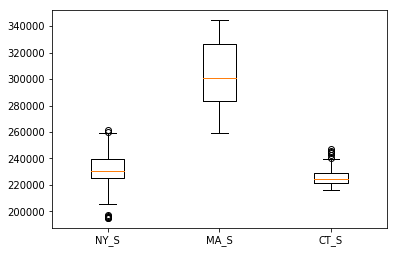

In [59]:
plt.boxplot([df_final.NY_S, df_final.MA_S, df_final.CT_S])
plt.xticks([1,2,3], ['NY_S','MA_S', 'CT_S'])
plt.show()

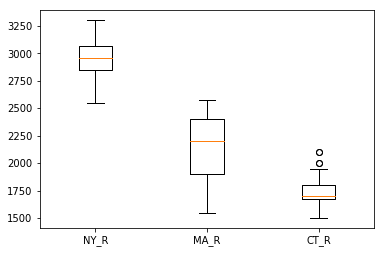

In [60]:
plt.boxplot([df_final.NY_R, df_final.MA_R, df_final.CT_R])
plt.xticks([1,2,3], ['NY_R','MA_R', 'CT_R'])
plt.show()

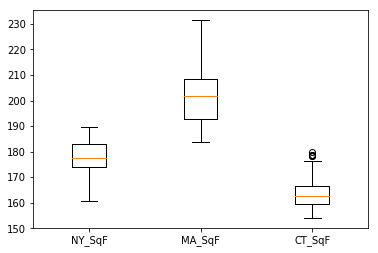

In [61]:
plt.boxplot([df_final.NY_SqF, df_final.MA_SqF, df_final.CT_SqF])
plt.xticks([1,2,3], ['NY_SqF','MA_SqF', 'CT_SqF'])
plt.show()

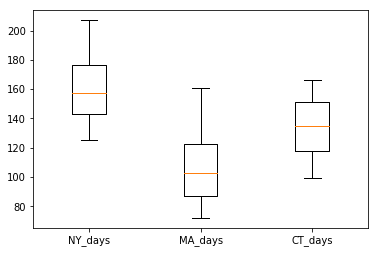

In [62]:
plt.boxplot([df_final.NY_days, df_final.MA_days, df_final.CT_days])
plt.xticks([1,2,3], ['NY_days','MA_days', 'CT_days'])
plt.show()

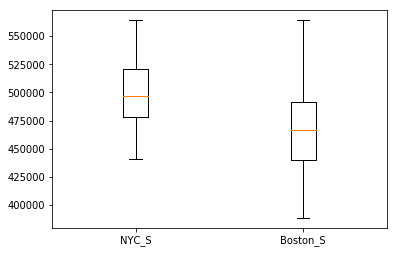

In [63]:
plt.boxplot([df_final.NYC_S, df_final.Boston_S])
plt.xticks([1,2], ['NYC_S','Boston_S'])
plt.show()

In [64]:
df_final.head()

,Unemployment Rate,Inflation Rate,Effective Federal Funds Rate,NY_S,MA_S,CT_S,NY_R,MA_R,CT_R,NY_SqF,...,Centralville,East Weymouth,Hyannis,East Forest Park,Centerville,Beacon Hill,North Chelmsford,South Yarmouth,West Yarmouth,Yarmouth Port
2010-01,9.8,1.6,0.11,230164.556962,279500.0,234400.0,2957.815789,2150.892045,1726.320225,180.250784,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,242000.0,248115.789474,320741.37931
2010-02,9.8,1.3,0.13,230164.556962,289800.0,238800.0,2957.815789,2150.892045,1700.000000,175.585284,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,245800.0,248115.789474,320741.37931
2010-03,9.9,1.1,0.16,230164.556962,289100.0,244600.0,2957.815789,1552.500000,1800.000000,177.476852,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,247400.0,248115.789474,320741.37931
2010-04,9.9,0.9,0.20,230164.556962,288300.0,242700.0,2957.815789,1675.000000,1900.000000,176.430518,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,254800.0,248115.789474,320741.37931
2010-05,9.6,0.9,0.20,230164.556962,281500.0,235600.0,2957.815789,1552.500000,1850.000000,186.623514,...,188956.25,267803.333333,227075.0,148742.307692,310867.741935,NaN,269822.580645,266000.0,248115.789474,320741.37931


In [65]:
for col in df_final.columns: 
    print(col)

Unemployment Rate
Inflation Rate
Effective Federal Funds Rate
NY_S
MA_S
CT_S
NY_R
MA_R
CT_R
NY_SqF
MA_SqF
CT_SqF
NY_days
MA_days
CT_days
NYC_S
Boston_S
Upper West Side
Upper East Side
East New York
Astoria
East Harlem
Gramercy
Coney Island
Fairport
St. Albans
Hollis
Bellerose
Great Kills
Eltingville
Nanuet
Yorktown Heights
Sutton Place
Turtle Bay
Maplewood
Eggertsville
Delmar
Tudor City
Kenmore
Arden Heights
Eastwood
Mariner's Harbor
Valley Cottage
Suffern
Rossville
Murray Hill
Mahopac
Greenridge
Midland Beach
Heritage Hills
Wykagyl
South Dorchester
Jamaica Plain
Brighton
South Boston
Hyde Park
West Roxbury
Forest Park
Back Bay
Sixteen Acres
South Weymouth
Charlestown
North Quincy
Centralville
East Weymouth
Hyannis
East Forest Park
Centerville
Beacon Hill
North Chelmsford
South Yarmouth
West Yarmouth
Yarmouth Port


In [66]:


X2 = df_final[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'Boston_S', 'NYC_S', 'Upper West Side',
'Upper East Side',
'East New York',
'East Harlem',
'Gramercy',
'Coney Island',
'Fairport',
'St. Albans',
'Hollis',
'Bellerose',
'Great Kills',
'Eltingville',
'Nanuet',
'Yorktown Heights',
'Sutton Place',
'Turtle Bay',
'Maplewood',
'Eggertsville',
'Delmar',
'Tudor City',
'Kenmore',
'Arden Heights',
'Eastwood',
'Valley Cottage',
'Rossville',
'Murray Hill',
'Mahopac',
'Greenridge',
'Heritage Hills',
'Wykagyl',
'South Dorchester',
'Jamaica Plain',
'Brighton',
'South Boston',
'Hyde Park',
'West Roxbury',
'Forest Park',
'Back Bay',
'Sixteen Acres',
'South Weymouth',
'Charlestown',
'North Quincy',
'Centralville',
'East Weymouth',
'Hyannis',
'East Forest Park',
'Centerville',
'North Chelmsford',
'South Yarmouth',
'West Yarmouth',
'Yarmouth Port']] 


In [67]:
df_final.isnull().sum()*100/df_final.count()


Unemployment Rate               0.0
Inflation Rate                  0.0
Effective Federal Funds Rate    0.0
NY_S                            0.0
MA_S                            0.0
                               ... 
Beacon Hill                     inf
North Chelmsford                0.0
South Yarmouth                  0.0
West Yarmouth                   0.0
Yarmouth Port                   0.0
Length: 73, dtype: float64

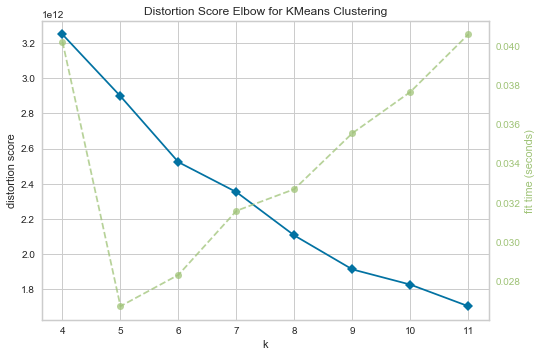

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X2)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [72]:
# Perform the necessary imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create scaler: scaler
scaler = StandardScaler(X2)

In [73]:
# Import KMeans
from sklearn.cluster import KMeans

model = KMeans(n_clusters=7)

# Fit model to points
model.fit(X2)

# Determine the cluster labels of new_points: labels
labels = model.predict(X2)

# Print cluster labels of new_points
print(labels)

[6 6 6 6 6 6 6 6 6 6 6 5 5 5 6 6 6 5 5 5 6 6 6 6 5 5 5 5 5 5 5 5 5 1 1 1 1
 1 1 1 1 1 5 5 5 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 2 2 2 0 0 0 0 0
 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [74]:
df_final['Label'] = labels 
print (df_final['Label'])

2010-01    6
2010-02    6
2010-03    6
2010-04    6
2010-05    6
          ..
2016-12    3
2017-01    3
2017-02    3
2017-03    3
2017-03    3
Name: Label, Length: 90, dtype: int32


In [80]:


X3 = df_final[['Label','Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'MA_S', 'CT_S', 'NY_R', 'MA_R', 'CT_R', 'NY_SqF', 'MA_SqF', 
                'CT_SqF', 'NY_days', 'MA_days', 'CT_days', 'Boston_S', 'NYC_S', 'Upper West Side',
'Upper East Side',
'East New York',
'East Harlem',
'Gramercy',
'Coney Island',
'Fairport',
'St. Albans',
'Hollis',
'Bellerose',
'Great Kills',
'Eltingville',
'Nanuet',
'Yorktown Heights',
'Sutton Place',
'Turtle Bay',
'Maplewood',
'Eggertsville',
'Delmar',
'Tudor City',
'Kenmore',
'Arden Heights',
'Eastwood',
'Valley Cottage',
'Rossville',
'Murray Hill',
'Mahopac',
'Greenridge',
'Heritage Hills',
'Wykagyl',
'South Dorchester',
'Jamaica Plain',
'Brighton',
'South Boston',
'Hyde Park',
'West Roxbury',
'Forest Park',
'Back Bay',
'Sixteen Acres',
'South Weymouth',
'Charlestown',
'North Quincy',
'Centralville',
'East Weymouth',
'Hyannis',
'East Forest Park',
'Centerville',
'North Chelmsford',
'South Yarmouth',
'West Yarmouth',
'Yarmouth Port']] 


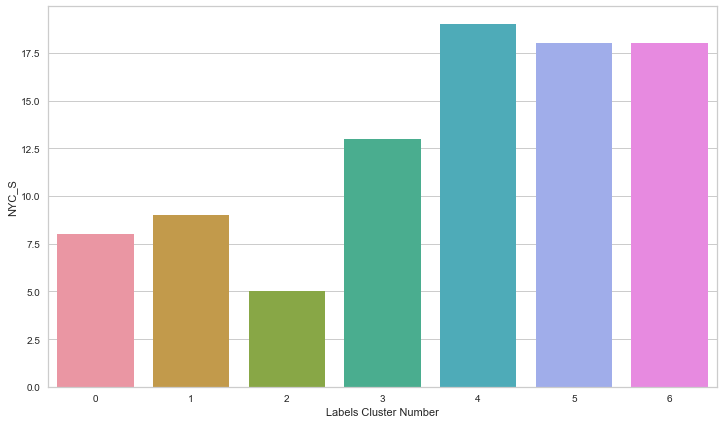

In [82]:
plt.figure(figsize=(12,7))
axis = sns.barplot(x= np.arange(0,7,1),y=df_final.groupby(['Label']).count()['NYC_S'].values)
x=axis.set_xlabel("Labels Cluster Number")
x=axis.set_ylabel("NYC_S")

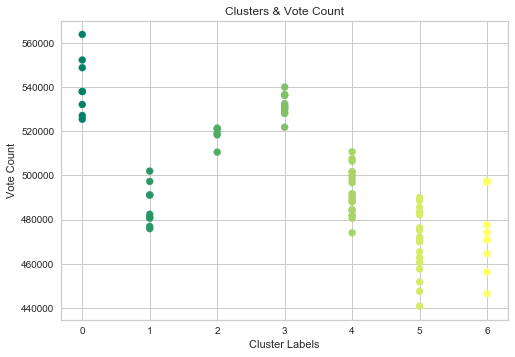

In [83]:
plt.scatter(X3['Label'], X3['NYC_S'], c = labels, cmap = 'summer' )
plt.title("Clusters & Vote Count")
plt.xlabel("Cluster Labels")
plt.ylabel("Vote Count")
plt.show()

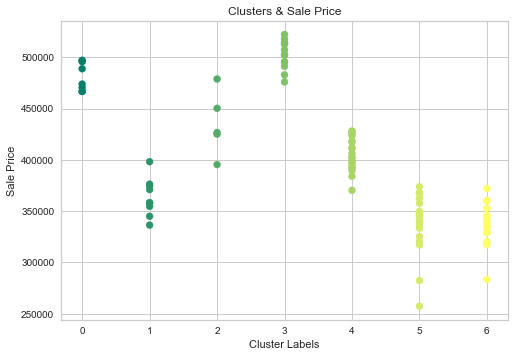

In [86]:


plt.scatter(X3['Label'], X3['Jamaica Plain'], c = labels, cmap = 'summer' )
plt.title("Clusters & Sale Price")
plt.xlabel("Cluster Labels")
plt.ylabel("Sale Price")
plt.show()

In [75]:
from sklearn.metrics import silhouette_samples, silhouette_score

silhouette_avg = silhouette_score(X2, labels)
print("The average silhouette_score is :", silhouette_avg)

The average silhouette_score is : 0.2523492881138963


In [70]:

import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'NY_R', 'NY_SqF', 'NY_days']] 
Y = df_final['NYC_S']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(lrm.coef_))
print('intercept: ' + str(lrm.intercept_))
print('score: ' + str(lrm.score(X,Y)))

The number of observations in training set is 72
The number of observations in test set is 18
R-squared of the model in the training set is: 0.7264825984651773
-----Test set statistics-----
R-squared of the model in the test set is: 0.7219274506675584
Mean absolute error of the prediction is: 11401.127969345114
Mean squared error of the prediction is: 196622253.30185783
Root mean squared error of the prediction is: 14022.205721706476
Mean absolute percentage error of the prediction is: 2.3531741113085447
coefficients: [-4.92972532e+03 -4.95742558e+03  9.00336960e+04 -5.51184913e-02
  6.49360029e+01 -1.10734057e+02 -1.39684893e+02]
intercept: 388389.610076376
score: 0.7275882160219904


In [71]:
from sklearn.linear_model import HuberRegressor
hr = HuberRegressor()

import warnings
warnings.filterwarnings(action="ignore")



X = df_final[['Unemployment Rate', 'Inflation Rate', 'Effective Federal Funds Rate', 
                'NY_S', 'NY_R', 'NY_SqF', 'NY_days']] 
Y = df_final['NYC_S']



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)


print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))


# We fit an OLS model using sklearn
hr = HuberRegressor()

hr.fit(X_train, Y_train)


# We are making predictions here
y_preds_train = hr.predict(X_train)
y_preds_test = hr.predict(X_test)

print("R-squared of the model in the training set is: {}".format(hr.score(X_train, Y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(hr.score(X_test, Y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(Y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(Y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(Y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((Y_test - y_preds_test) / Y_test)) * 100))


print('coefficients: ' + str(hr.coef_))
print('intercept: ' + str(hr.intercept_))
print('score: ' + str(hr.score(X,Y)))

The number of observations in training set is 72
The number of observations in test set is 18
R-squared of the model in the training set is: 0.2718869352852602
-----Test set statistics-----
R-squared of the model in the test set is: -0.7525620454132493
Mean absolute error of the prediction is: 24197.568875602767
Mean squared error of the prediction is: 1239218683.2095323
Root mean squared error of the prediction is: 35202.538022272376
Mean absolute percentage error of the prediction is: 5.03509386084289
coefficients: [-25.81893438  14.96446932   1.28358347   0.8832949   99.32238085
 -16.25808582  47.28277262]
intercept: 484.89704125911084
score: 0.07209713961875253
